# SQLi Detector Model Evaluation

Compare multiple generations of trained models against the evaluation dataset.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## 1. Configuration

Specify how many models you want to evaluate and their paths.

In [2]:
# Number of models to evaluate
NUM_MODELS = 2  # Change this to the number of model generations you have

# Define your models here - add/remove entries as needed
MODELS = [
    {
        "name": "Generation 1",
        "model_path": "generations/1st_train_session/sqli_detector_model.joblib",
        "vectorizer_path": "generations/1st_train_session/sqli_vectorizer.joblib"
    },
    {
        "name": "Generation 2",
        "model_path": "generations/2nd_train_session/sqli_detector_model.joblib",
        "vectorizer_path": "generations/2nd_train_session/sqli_vectorizer.joblib"
    },
    {
         "name": "Generation 3",
         "model_path": "generations/3rd_train_session/sqli_detector_model.joblib",
         "vectorizer_path": "generations/3rd_train_session/sqli_vectorizer.joblib"
    },
    {
         "name": "Generation 4",
         "model_path": "generations/4th_train_session/sqli_detector_model.joblib",
         "vectorizer_path": "generations/4th_train_session/sqli_vectorizer.joblib"
    },
]

# Evaluation dataset path
EVAL_DATASET = "evaluation_dataset.csv"

print(f"Configured to evaluate {len(MODELS)} model(s)")

Configured to evaluate 4 model(s)


## 2. Load Evaluation Dataset

In [3]:
# Load the evaluation dataset
df = pd.read_csv(EVAL_DATASET)

print(f"Loaded {len(df)} evaluation queries")
print(f"\nLabel distribution:")
print(df['Label'].value_counts().rename({0: 'Benign', 1: 'Malicious'}))

Loaded 30919 evaluation queries

Label distribution:
Label
Benign       19537
Malicious    11382
Name: count, dtype: int64


In [4]:
# Extract features and labels
X_eval = df['Query'].tolist()
y_true = df['Label'].values

print(f"Ready to evaluate {len(X_eval)} queries")

Ready to evaluate 30919 queries


## 3. Load Models and Evaluate

In [5]:
def load_model_and_vectorizer(model_config):
    """Load a model and its vectorizer."""
    try:
        model = joblib.load(model_config['model_path'])
        vectorizer = joblib.load(model_config['vectorizer_path'])
        return model, vectorizer, None
    except Exception as e:
        return None, None, str(e)

def evaluate_model(model, vectorizer, X, y_true):
    """Evaluate a model and return metrics."""
    X_transformed = vectorizer.transform(X)
    y_pred = model.predict(X_transformed)
    
    # Try to get probabilities for ROC-AUC
    try:
        y_proba = model.predict_proba(X_transformed)[:, 1]
        roc_auc = roc_auc_score(y_true, y_proba)
    except:
        y_proba = None
        roc_auc = None
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    return metrics

# Evaluate all models
results = {}
for config in MODELS:
    name = config['name']
    print(f"\n{'='*60}")
    print(f"Evaluating: {name}")
    print(f"{'='*60}")
    
    model, vectorizer, error = load_model_and_vectorizer(config)
    
    if error:
        print(f"❌ Failed to load: {error}")
        results[name] = {'error': error}
        continue
    
    print(f"✅ Model loaded successfully")
    
    metrics = evaluate_model(model, vectorizer, X_eval, y_true)
    results[name] = metrics
    
    print(f"\n📊 Results:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1 Score:  {metrics['f1']:.4f}")
    if metrics['roc_auc']:
        print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")


Evaluating: Generation 1
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.3899
   Precision: 0.3763
   Recall:    0.9996
   F1 Score:  0.5467
   ROC-AUC:   0.5277

Evaluating: Generation 2
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.5280
   Precision: 0.4382
   Recall:    0.9998
   F1 Score:  0.6093
   ROC-AUC:   0.8971

Evaluating: Generation 3
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.6329
   Precision: 0.5007
   Recall:    0.9997
   F1 Score:  0.6673
   ROC-AUC:   0.9385

Evaluating: Generation 4
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.6704
   Precision: 0.6027
   Recall:    0.3067
   F1 Score:  0.4065
   ROC-AUC:   0.7160


## 4. Comparison Summary

In [6]:
# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    if 'error' not in metrics:
        comparison_data.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
}).background_gradient(cmap='RdYlGn', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score']))


MODEL COMPARISON SUMMARY


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Generation 1,0.3899,0.3763,0.9996,0.5467,0.527734
1,Generation 2,0.5280,0.4382,0.9998,0.6093,0.897099
2,Generation 3,0.6329,0.5007,0.9997,0.6673,0.938497
3,Generation 4,0.6704,0.6027,0.3067,0.4065,0.716032


## 5. Confusion Matrices

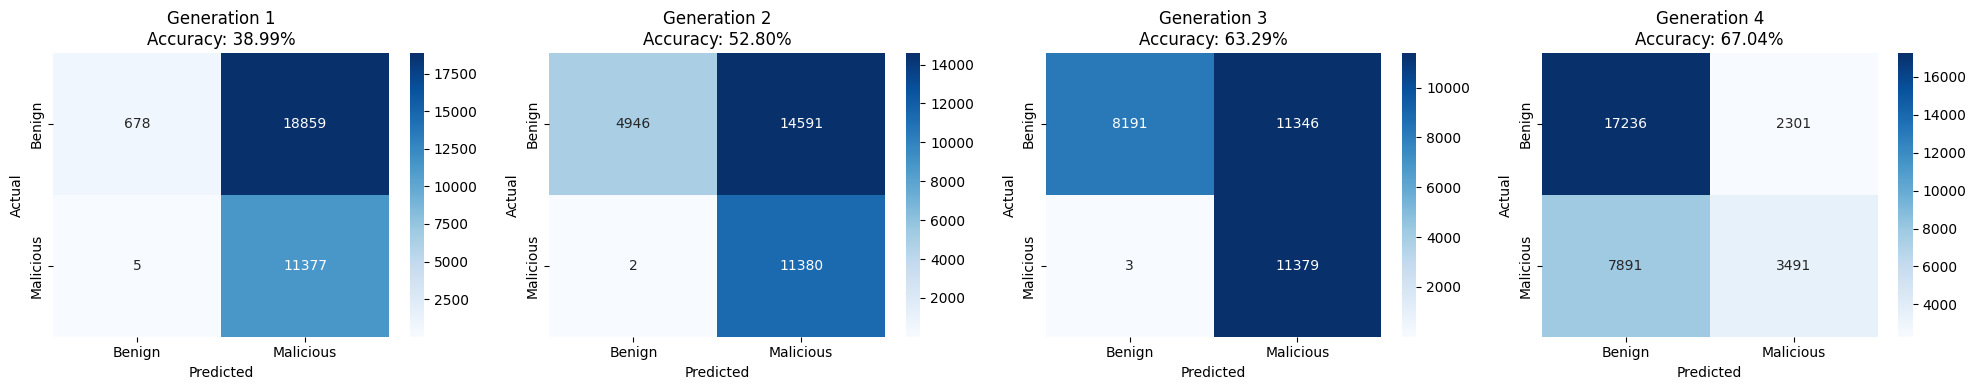


💾 Saved: model_comparison_confusion.png


In [7]:
# Plot confusion matrices for all models
valid_models = [(name, m) for name, m in results.items() if 'error' not in m]
n_models = len(valid_models)

if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, metrics) in zip(axes, valid_models):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Benign', 'Malicious'],
                    yticklabels=['Benign', 'Malicious'])
        ax.set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.2%}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('model_comparison_confusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Saved: model_comparison_confusion.png")

## 6. Metrics Bar Chart

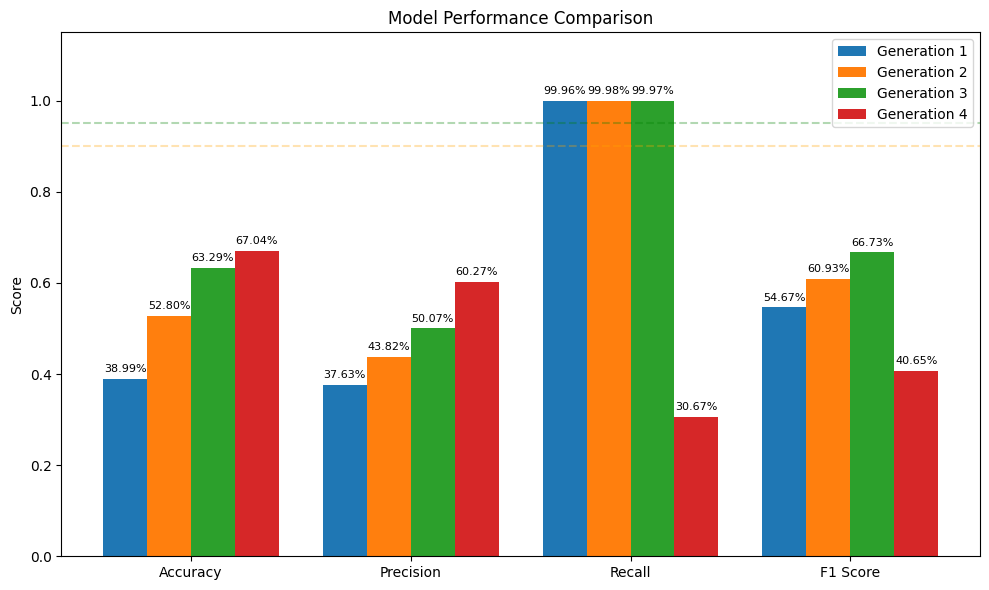


💾 Saved: model_comparison_metrics.png


In [8]:
# Bar chart comparing metrics
if len(comparison_data) > 0:
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics_to_plot))
    width = 0.8 / len(comparison_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, row in enumerate(comparison_data):
        values = [row[m] for m in metrics_to_plot]
        offset = (i - len(comparison_data)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=row['Model'])
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2%}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.legend()
    ax.set_ylim(0, 1.15)
    ax.axhline(y=0.95, color='g', linestyle='--', alpha=0.3, label='95% threshold')
    ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.3, label='90% threshold')
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Saved: model_comparison_metrics.png")

## 7. Misclassified Examples

In [9]:
def show_misclassified(name, y_pred, df, n=20):
    """Show misclassified examples."""
    df_analysis = df.copy()
    df_analysis['predicted'] = y_pred
    df_analysis['correct'] = df_analysis['Label'] == df_analysis['predicted']
    
    misclassified = df_analysis[~df_analysis['correct']]
    
    # False Positives (benign marked as malicious)
    fp = misclassified[misclassified['Label'] == 0]
    
    # False Negatives (malicious marked as benign)
    fn = misclassified[misclassified['Label'] == 1]
    
    return fp, fn, len(misclassified)

# Show misclassified for each model
for name, metrics in results.items():
    if 'error' not in metrics:
        print(f"\n{'='*60}")
        print(f"Misclassified Examples: {name}")
        print(f"{'='*60}")
        
        fp, fn, total_wrong = show_misclassified(name, metrics['y_pred'], df)
        
        print(f"\nTotal misclassified: {total_wrong} / {len(df)} ({total_wrong/len(df):.2%})")
        
        print(f"\n🔴 FALSE POSITIVES (Benign → Malicious): {len(fp)}")
        if len(fp) > 0:
            display(fp[['Query']].head(15))
        
        print(f"\n🟡 FALSE NEGATIVES (Malicious → Benign): {len(fn)}")
        if len(fn) > 0:
            display(fn[['Query']].head(15))


Misclassified Examples: Generation 1

Total misclassified: 18864 / 30919 (61.01%)

🔴 FALSE POSITIVES (Benign → Malicious): 18859


,Query
11330,99745017c
11331,ejerci78
11332,47209
11333,"calle valencia de don juan 161, 7?d"
11334,b3r3al
11335,46942381w
11336,elder@parcalia.hn
11337,24596413y
11338,compte
11339,2366



🟡 FALSE NEGATIVES (Malicious → Benign): 5


,Query
1915,"1"" ) ) ) or 7552 = ( select co..."
4201,"1%"" ) ) or 7552 = ( select count ..."
5255,"1"" ) ) or 7552 = ( select count ..."
10501,"1%"" ) ) ) or 7552 = ( select c..."
11317,"-5703' ) or elt ( 2972 = 8708,8708 )"



Misclassified Examples: Generation 2

Total misclassified: 14593 / 30919 (47.20%)

🔴 FALSE POSITIVES (Benign → Malicious): 14591


,Query
11330,99745017c
11331,ejerci78
11332,47209
11333,"calle valencia de don juan 161, 7?d"
11334,b3r3al
11335,46942381w
11336,elder@parcalia.hn
11337,24596413y
11338,compte
11339,2366



🟡 FALSE NEGATIVES (Malicious → Benign): 2


,Query
120,truncate
193,1;SELECT *



Misclassified Examples: Generation 3

Total misclassified: 11349 / 30919 (36.71%)

🔴 FALSE POSITIVES (Benign → Malicious): 11346


,Query
11330,99745017c
11331,ejerci78
11332,47209
11333,"calle valencia de don juan 161, 7?d"
11334,b3r3al
11335,46942381w
11337,24596413y
11338,compte
11339,2366
11340,leshowit



🟡 FALSE NEGATIVES (Malicious → Benign): 3


,Query
120,truncate
193,1;SELECT *
200,procedure



Misclassified Examples: Generation 4

Total misclassified: 10192 / 30919 (32.96%)

🔴 FALSE POSITIVES (Benign → Malicious): 2301


,Query
11431,lenya@fbi-criminal-network.com.mil
11447,mirabel
11535,comalada
11568,mieza
11622,minera dauns
11736,c/ grabador david roberts 154 1-h
11785,incom1a5abl8mente
11989,tiru corominas
12155,ermina
12185,pasivamente



🟡 FALSE NEGATIVES (Malicious → Benign): 7891


,Query
1,create user name identified by pass123 tempora...
7,"1; ( load_file ( char ( 47,101,116,99,47..."
19,distinct
21,1 and ascii ( lower ( substring ( ( ...
25,insert
30,"or 1 = 1 or """" ="
39,"1; ( load_file ( char ( 47,101,116,99,47..."
54,PRINT
60,or 2 between 1 and 3
72,char%4039%41%2b%40SELECT


## 8. Export Results

In [10]:
# Export comparison to CSV
if len(comparison_data) > 0:
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    print("💾 Saved: model_comparison_results.csv")

# Export detailed predictions for each model
for name, metrics in results.items():
    if 'error' not in metrics:
        df_export = df.copy()
        df_export['predicted'] = metrics['y_pred']
        df_export['correct'] = df_export['Label'] == df_export['predicted']
        if metrics['y_proba'] is not None:
            df_export['malicious_probability'] = metrics['y_proba']
        
        filename = f"{name.lower().replace(' ', '_')}_predictions.csv"
        df_export.to_csv(filename, index=False)
        print(f"💾 Saved: {filename}")

print("\n✅ All results exported!")

💾 Saved: model_comparison_results.csv
💾 Saved: generation_1_predictions.csv
💾 Saved: generation_2_predictions.csv
💾 Saved: generation_3_predictions.csv
💾 Saved: generation_4_predictions.csv

✅ All results exported!
